# Reproducing idealised exoplanet simulations
## Source: Mayne et al. (2014)

### Synopsis

This notebook goes through the following steps:
1. Load the UM output using `iris`, thus representing each of the output variables as `iris.cube.Cube`.
2. Interpolate `iris` cubes from the levels of constant height to sigma-pressure levels $\sigma=p/p_s$ using the `python-stratify`.
3. Average the data over time and/or longitude using functions from `aeolus`.
4. Plot the results and save them to the `../plots/` directory.
   * Using the "old" style of the original paper
   * Using modern `matplotlib` style

### Import the necessary libraries

Standard library

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
from functools import partial

Scientific stack

In [3]:
import iris
import matplotlib.colors as mcol
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
from iris.experimental import stratify
from matplotlib.offsetbox import AnchoredText

In [4]:
from tqdm.notebook import tqdm

aeolus

In [5]:
from aeolus.calc import spatial_mean, time_mean, zonal_mean
from aeolus.coord import (
    get_cube_rel_days,
    get_xy_coords,
    regrid_3d,
)
from aeolus.model import um
from aeolus.subset import extract_last_n_days

local scripts

In [6]:
import mypaths
from plot_func import cube_stats_string, figsave, use_style

### Some global definitions

Apply a custom `matplotlib` style.

In [7]:
use_style()

Create a path effects object to highlight contours for later

In [8]:
PE = [PathEffects.withStroke(linewidth=0.5, foreground="w")]

Select the run configuration

In [9]:
planet = "earth"
SIM_LABEL = "Held-Suarez test"
# const = init_const(planet)

Common directory where to save plots.

In [10]:
plot_dir = mypaths.plotdir / "mayne2014_gmd_plots"

Update the `um` name container

In [11]:
um.s_p = "sigma_p"
um.height = "height_above_reference_ellipsoid"

### Load the data into a cube list

Use `sadir` from the `mypaths` script to find the data. Adapt the file path to the one on your machine in the `mypaths.py` script.

In [12]:
%%time
cl = iris.load(str(mypaths.sadir / "held_suarez" / "atmosa.p*"))

CPU times: user 1min 48s, sys: 2.3 s, total: 1min 50s
Wall time: 1min 51s


### Interpolate and clean the data

In [13]:
selected_cubes = cl.extract_cubes([um.pres, um.temp, um.u, um.v, um.p_sfc])

Select days 200-1200:

In [14]:
selected_cubes = iris.cube.CubeList(
    [extract_last_n_days(i, 1000) for i in selected_cubes]
)  # Select days 200-1200.

In [15]:
# Add planet configuration to the cubes.

# add_planet_conf_to_cubes(selected_cubes, const)

Calculate sigma-pressure coordinate: $\sigma=p/p_s$

In [16]:
sigma_pressure = selected_cubes.extract_cube(um.pres) / selected_cubes.extract_cube(um.p_sfc)
sigma_pressure.rename(um.s_p)

In [17]:
selected_cubes_4d = selected_cubes.extract([um.pres, um.temp, um.u, um.v])  # select only 4d cubes

selected_cubes_4d.append(sigma_pressure)

In [18]:
print(selected_cubes_4d)

0: air_pressure / (Pa)                 (time: 100; model_level_number: 33; latitude: 90; longitude: 144)
1: air_temperature / (K)               (time: 100; model_level_number: 32; latitude: 90; longitude: 144)
2: x_wind / (m s-1)                    (time: 100; model_level_number: 32; latitude: 90; longitude: 144)
3: y_wind / (m s-1)                    (time: 100; model_level_number: 32; latitude: 91; longitude: 144)
4: sigma_p / (1)                       (time: 100; model_level_number: 33; latitude: 90; longitude: 144)


#### Interpolate selected data to a common height-latitude-longitude grid

In [19]:
# target_cube = selected_cubes.extract_cube(um.pres)

In [20]:
height_lev_cubes = iris.cube.CubeList()
for cube in tqdm(selected_cubes_4d[:-1]):
    height_lev_cubes.append(regrid_3d(cube, sigma_pressure, model=um))

  0%|          | 0/4 [00:00<?, ?it/s]

#### Interpolate selected data to sigma-pressure levels

Create a callable to pass to the interpolation routine. Use linear extrapolation.

In [21]:
INTERPOLATOR = partial(
    stratify.stratify.interpolate,
    interpolation=stratify.stratify.INTERPOLATE_LINEAR,
    extrapolation=stratify.stratify.EXTRAPOLATE_LINEAR,
)

Create an array of sigma levels, using the table A1 in Mayne et al. (2014).

In [22]:
sigma_levels = np.array(
    [
        1.0,
        0.975,  # additional level for horiz. sections
        0.97,
        0.94,
        0.91,
        0.88,
        0.84,
        0.81,
        0.78,
        0.75,
        0.72,
        0.69,
        0.66,
        0.63,
        0.6,
        0.57,
        0.53,
        0.525,  # additional level for horiz. sections
        0.5,
        0.47,
        0.44,
        0.41,
        0.38,
        0.35,
        0.32,
        0.28,
        0.26,
        0.225,  # additional level for horiz. sections
        0.22,
        0.19,
        0.16,
        0.13,
        0.1,
        0.07,
        0.04,
        0.01,
    ]
)

#### Test the interpolation using the cube of height

In [23]:
cube_of_height = cl.extract(um.height)[0]

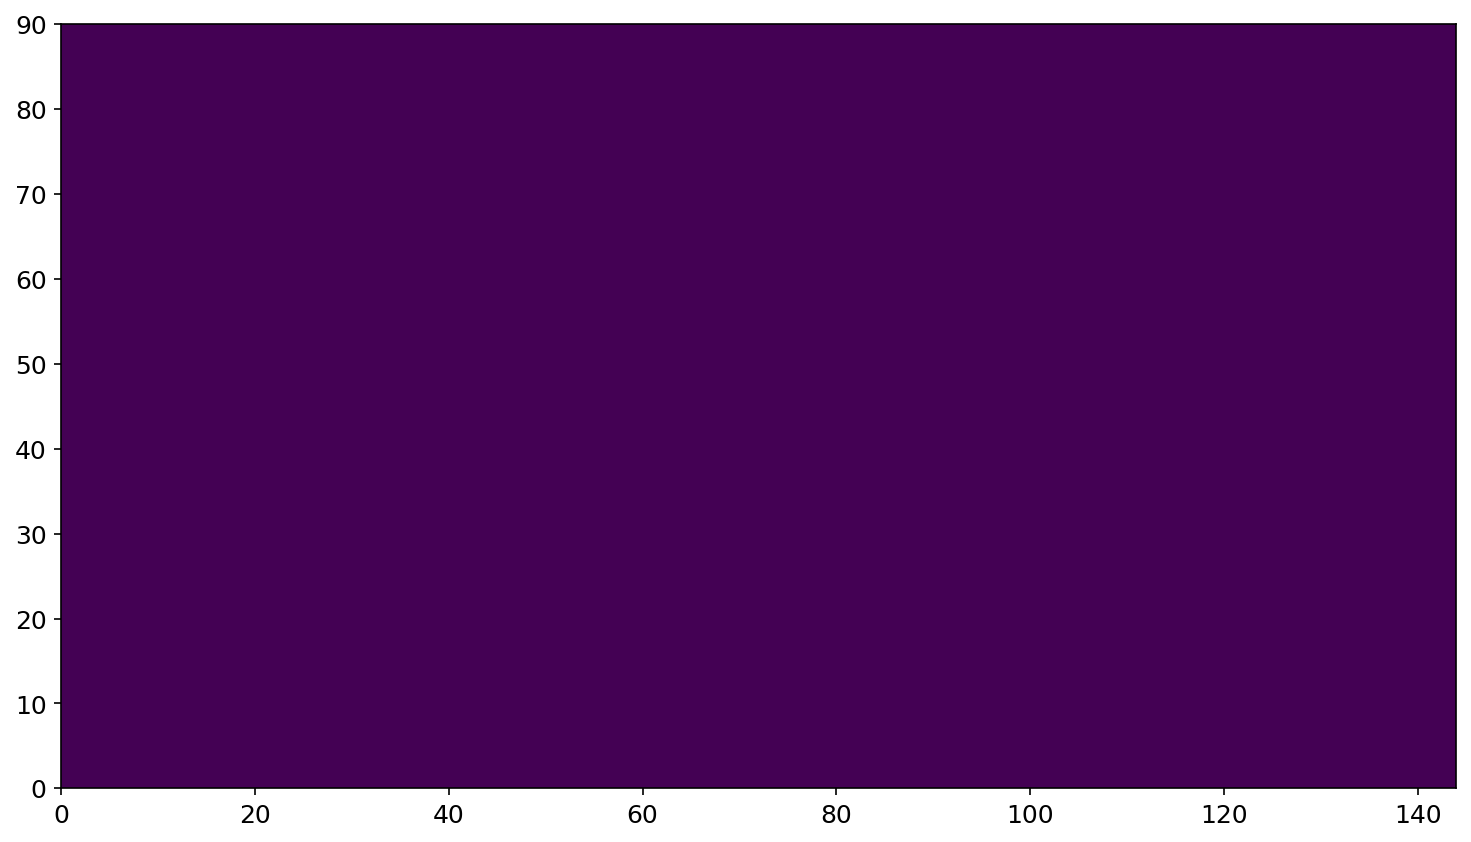

In [24]:
plt.pcolormesh(cube_of_height[0, ...].data)

In [25]:
cube_of_height_slev = stratify.relevel(
    cube_of_height,
    sigma_pressure[0, ...],
    sigma_levels,
    axis=um.z,
    interpolator=INTERPOLATOR,
)

Text(0.5, 1.0, '(test) p=0.57')

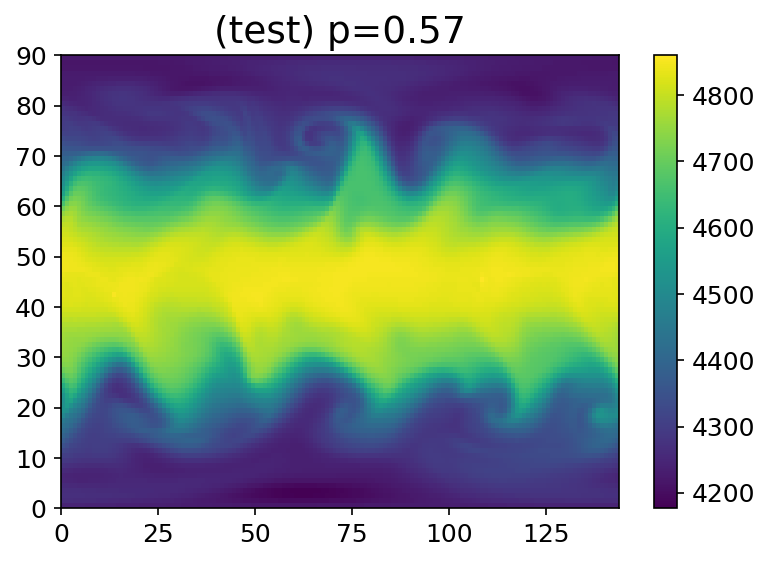

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))
p0 = ax.pcolormesh(cube_of_height_slev[15, ...].data)
fig.colorbar(p0)
ax.set_title(f"(test) p={cube_of_height_slev[15, ...].coord(um.s_p).points[0]}")

In [27]:
cube_of_height_slev_gm = spatial_mean(cube_of_height_slev, model=um)
normalised_height = cube_of_height_slev_gm.data / cube_of_height_slev_gm.data.max()

Compare with Table A1 in the paper.

In [28]:
[*zip(sigma_levels, np.round(normalised_height, decimals=6))]

[(1.0, 0.0),
 (0.975, 0.00765),
 (0.97, 0.00918),
 (0.94, 0.01836),
 (0.91, 0.02754),
 (0.88, 0.037008),
 (0.84, 0.050593),
 (0.81, 0.060782),
 (0.78, 0.071301),
 (0.75, 0.082497),
 (0.72, 0.093739),
 (0.69, 0.105362),
 (0.66, 0.117634),
 (0.63, 0.130032),
 (0.6, 0.143096),
 (0.57, 0.156682),
 (0.53, 0.175542),
 (0.525, 0.177986),
 (0.5, 0.190457),
 (0.47, 0.206043),
 (0.44, 0.222396),
 (0.41, 0.239657),
 (0.38, 0.257798),
 (0.35, 0.277244),
 (0.32, 0.297732),
 (0.28, 0.327647),
 (0.26, 0.344114),
 (0.225, 0.375086),
 (0.22, 0.379858),
 (0.19, 0.41033),
 (0.16, 0.445306),
 (0.13, 0.486921),
 (0.1, 0.538944),
 (0.07, 0.610061),
 (0.04, 0.721977),
 (0.01, 1.0)]

#### Interpolate the main data

In [29]:
sigma_lev_cubes = iris.cube.CubeList()
for cube in tqdm(height_lev_cubes):
    cube_slev = stratify.relevel(
        cube,
        sigma_pressure,
        sigma_levels,
        axis=um.z,
        interpolator=INTERPOLATOR,
    )
    sigma_lev_cubes.append(cube_slev)

  0%|          | 0/4 [00:00<?, ?it/s]

In [30]:
sigma_lev_cubes[0].coord(um.s_p)

DimCoord(array([1.   , 0.975, 0.97 , 0.94 , 0.91 , 0.88 , 0.84 , 0.81 , 0.78 ,
       0.75 , 0.72 , 0.69 , 0.66 , 0.63 , 0.6  , 0.57 , 0.53 , 0.525,
       0.5  , 0.47 , 0.44 , 0.41 , 0.38 , 0.35 , 0.32 , 0.28 , 0.26 ,
       0.225, 0.22 , 0.19 , 0.16 , 0.13 , 0.1  , 0.07 , 0.04 , 0.01 ]), standard_name=None, units=Unit('1'), long_name='sigma_p', attributes={'source': 'Data from Met Office Unified Model', 'um_version': '11.9'})

In [31]:
airtemp = sigma_lev_cubes.extract_cube(um.temp)

Get latitude and longitude points (they are the same for all variables in this dataset).

In [32]:
lons, lats = get_xy_coords(airtemp, model=um)
lons, lats = lons.points, lats.points

check the values

In [33]:
lons

array([  1.25,   3.75,   6.25,   8.75,  11.25,  13.75,  16.25,  18.75,
        21.25,  23.75,  26.25,  28.75,  31.25,  33.75,  36.25,  38.75,
        41.25,  43.75,  46.25,  48.75,  51.25,  53.75,  56.25,  58.75,
        61.25,  63.75,  66.25,  68.75,  71.25,  73.75,  76.25,  78.75,
        81.25,  83.75,  86.25,  88.75,  91.25,  93.75,  96.25,  98.75,
       101.25, 103.75, 106.25, 108.75, 111.25, 113.75, 116.25, 118.75,
       121.25, 123.75, 126.25, 128.75, 131.25, 133.75, 136.25, 138.75,
       141.25, 143.75, 146.25, 148.75, 151.25, 153.75, 156.25, 158.75,
       161.25, 163.75, 166.25, 168.75, 171.25, 173.75, 176.25, 178.75,
       181.25, 183.75, 186.25, 188.75, 191.25, 193.75, 196.25, 198.75,
       201.25, 203.75, 206.25, 208.75, 211.25, 213.75, 216.25, 218.75,
       221.25, 223.75, 226.25, 228.75, 231.25, 233.75, 236.25, 238.75,
       241.25, 243.75, 246.25, 248.75, 251.25, 253.75, 256.25, 258.75,
       261.25, 263.75, 266.25, 268.75, 271.25, 273.75, 276.25, 278.75,
      

### Plot the results

**Figure 2.** Time and zonal mean of air temperature on sigma levels.

In [34]:
airtemp_tzm = time_mean(zonal_mean(airtemp))

In [35]:
airtemp_tzm

<iris 'Cube' of air_temperature / (K) (sigma_p: 36; latitude: 90)>

##### An old-school version for direct comparison with the paper

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__airtemp__time_zonal_mean.png


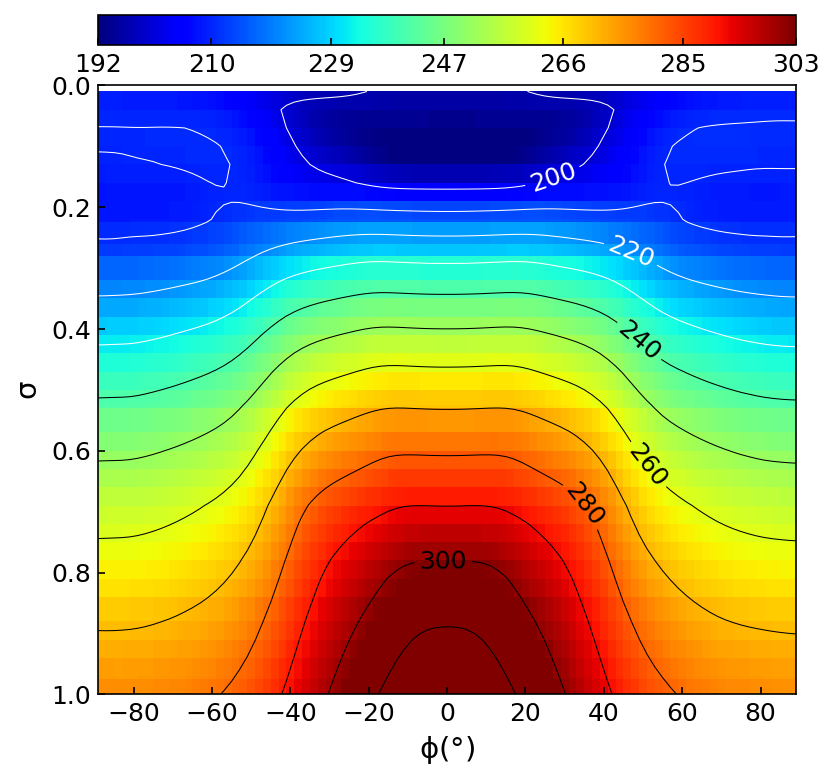

In [36]:
fig, (cax, ax) = plt.subplots(
    nrows=2,
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [0.05, 1], "hspace": 0.125},
)

p0 = ax.pcolormesh(lats, sigma_levels, airtemp_tzm.data, cmap="jet", vmin=192, vmax=303)
p1 = ax.contour(
    lats,
    sigma_levels,
    airtemp_tzm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(240, 400, 10),
)
c1 = ax.clabel(p1, levels=np.arange(240, 400, 20), fmt="%.0f", use_clabeltext=True)
p2 = ax.contour(
    lats,
    sigma_levels,
    airtemp_tzm.data,
    colors="w",
    linewidths=0.5,
    levels=np.arange(100, 240, 10),
)
c2 = ax.clabel(p2, levels=np.arange(100, 240, 20), fmt="%.0f", use_clabeltext=True)
ax.set_ylim([1, 0])
ax.tick_params(direction="in")
ax.set_xticks(np.arange(-80, 81, 20))

cb = fig.colorbar(p0, orientation="horizontal", cax=cax)
cb.ax.tick_params(direction="in")
cb.set_ticks([192, 210, 229, 247, 266, 285, 303])

ax.set_xlabel("$\phi$($\degree$)")
ax.set_ylabel("$\sigma$")

imgname = plot_dir / "um__held_suarez__airtemp__time_zonal_mean"
figsave(fig, imgname, stamp=False)

Note that figsave takes optional arguments. You can also change `matplotlib`'s defaults in the `simple.mplstyle` style sheet or using `plt.rcParams` in the notebook itself.

##### A better and simpler version

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__airtemp__time_zonal_mean__new.png


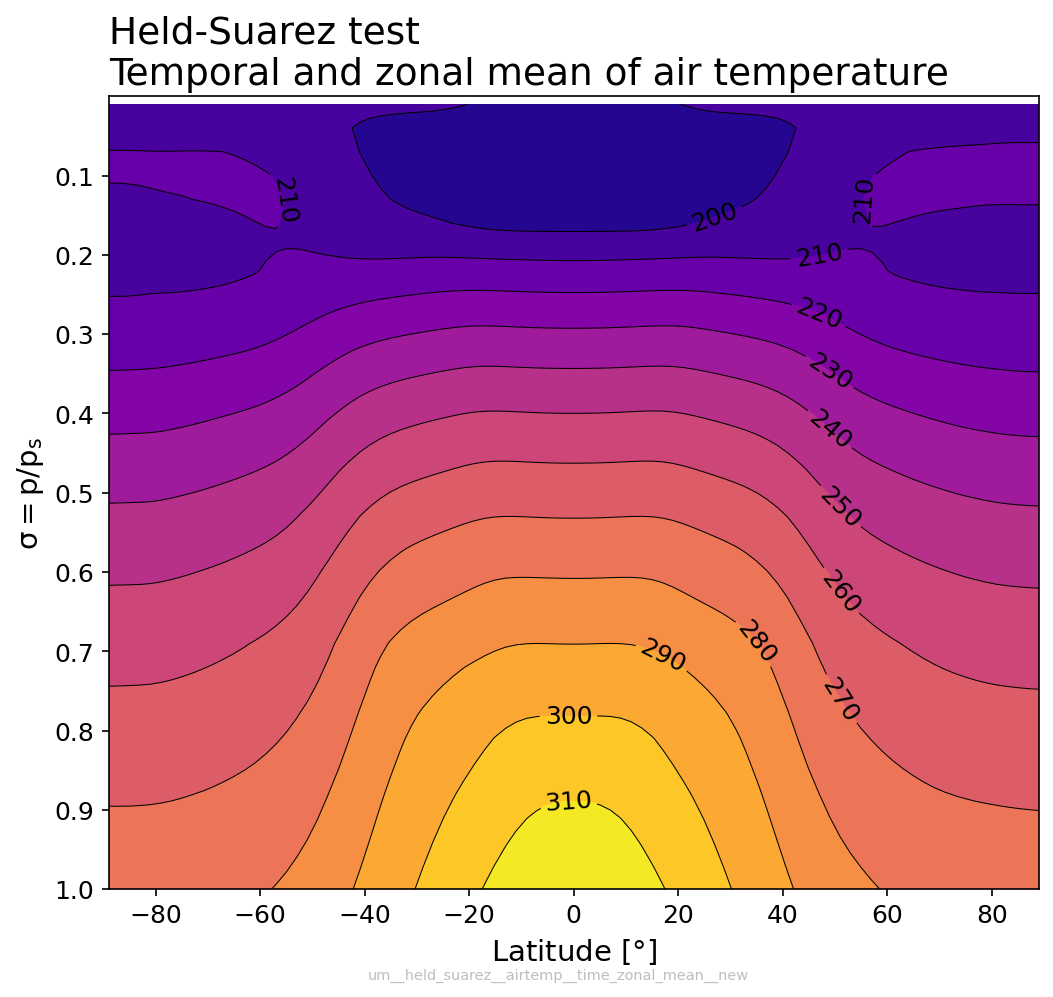

In [37]:
fig, ax = plt.subplots(figsize=(8, 7))

p0 = ax.contourf(
    lats,
    sigma_levels,
    airtemp_tzm.data,
    cmap="plasma",
    levels=np.arange(190, 321, 10),
)
p1 = ax.contour(
    lats,
    sigma_levels,
    airtemp_tzm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(200, 400, 10),
)
c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)

ax.set_xticks(np.arange(-80, 81, 20))
ax.set_yticks(np.arange(1.0, 0.0, -0.1))
ax.set_ylim([1, 0])

ax.set_xlabel("Latitude [$\degree$]")
ax.set_ylabel("$\sigma=p/p_s$")
ax.set_title("Held-Suarez test\nTemporal and zonal mean of air temperature", loc="left")

imgname = plot_dir / "um__held_suarez__airtemp__time_zonal_mean__new"
figsave(fig, imgname)

**Figure 3.** Time and zonal mean of zonal wind on sigma levels.

In [38]:
u_tzm = time_mean(zonal_mean(sigma_lev_cubes.extract_cube(um.u)))

##### An old-school version for direct comparison with the paper

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__u__time_zonal_mean.png


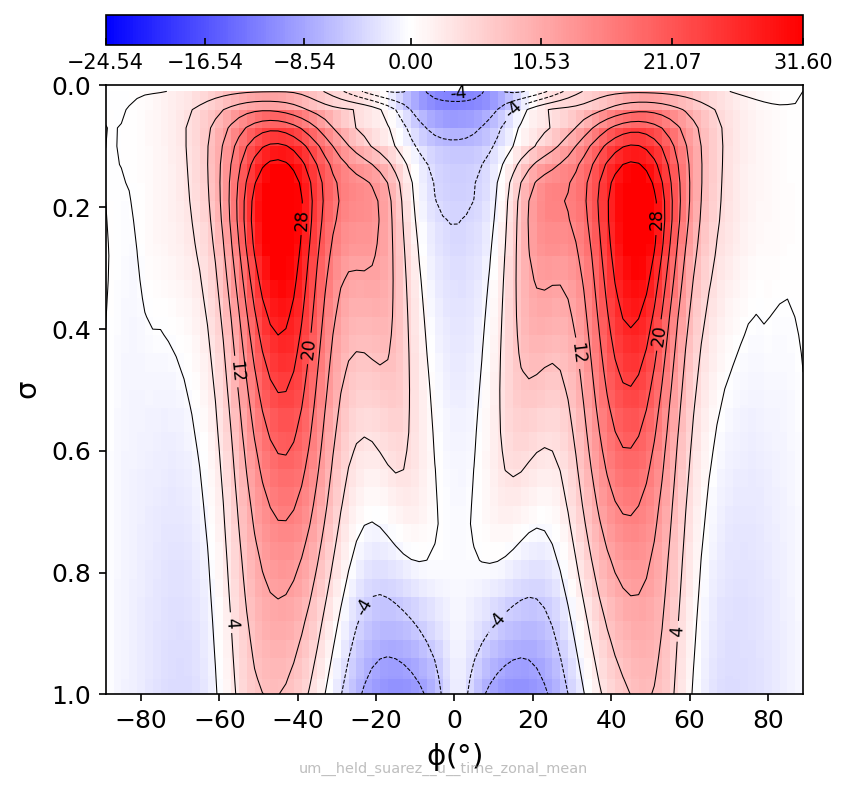

In [39]:
fig, (cax, ax) = plt.subplots(
    nrows=2,
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [0.05, 1], "hspace": 0.125},
)

p0 = ax.pcolormesh(
    lats,
    sigma_levels,
    u_tzm.data,
    cmap="bwr",
    norm=mcol.TwoSlopeNorm(vcenter=0, vmin=-24.54, vmax=31.60),
)
p1 = ax.contour(
    lats,
    sigma_levels,
    u_tzm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(-28, 29, 4),
)
c1 = ax.clabel(
    p1,
    levels=np.arange(-28, 29, 8),
    fmt="%.0f",
    fontsize="x-small",
    use_clabeltext=True,
)

cb = fig.colorbar(p0, orientation="horizontal", cax=cax)
cb.ax.tick_params(direction="in", labelsize="small")
cb.set_ticks([-24.54, -16.54, -8.54, 0.00, 10.53, 21.07, 31.60])
# cb.ax.set_xlim([-24.54, 31.60])

ax.set_ylim([1, 0])
ax.set_xlabel("$\phi$($\degree$)")
ax.set_ylabel("$\sigma$")

imgname = plot_dir / "um__held_suarez__u__time_zonal_mean"
figsave(fig, imgname)

##### A better and simpler version

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__u__time_zonal_mean__new.png


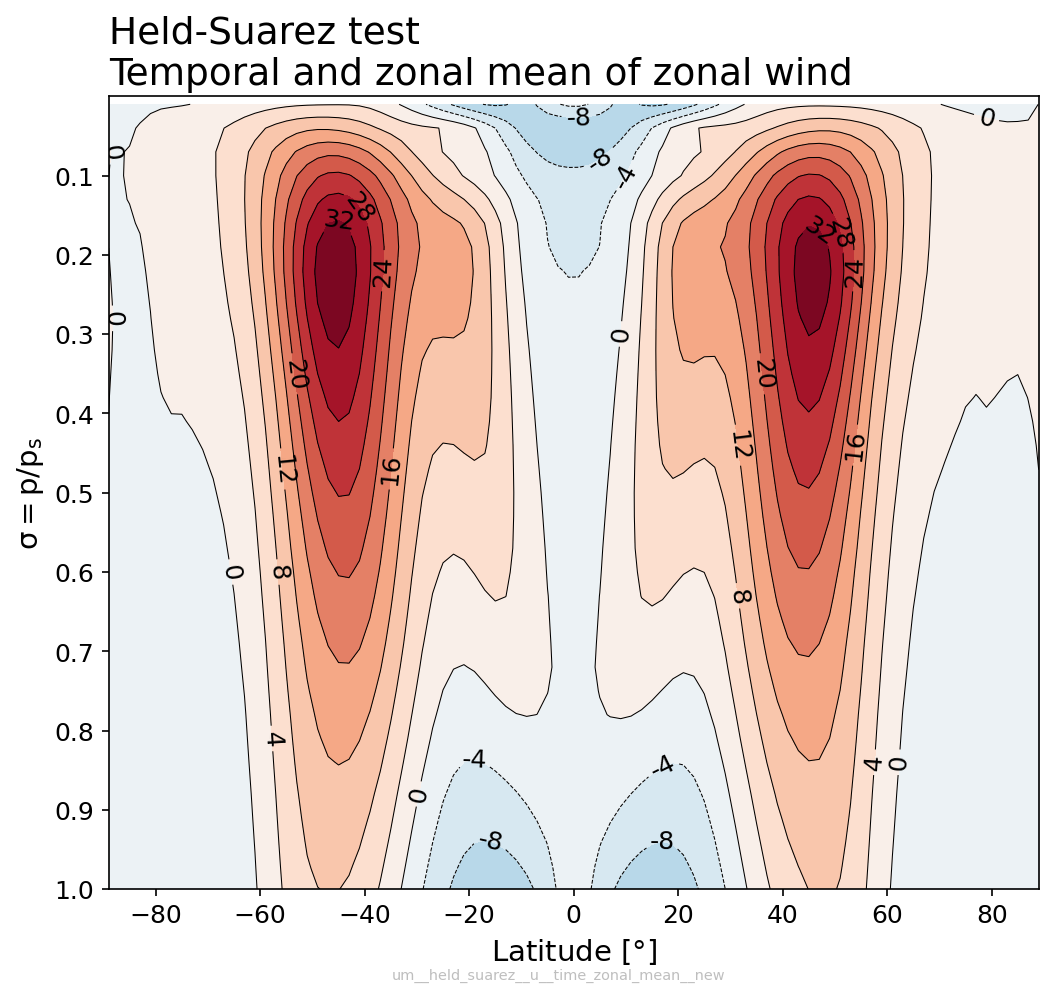

In [40]:
fig, ax = plt.subplots(figsize=(8, 7))

p0 = ax.contourf(
    lats,
    sigma_levels,
    u_tzm.data,
    cmap="RdBu_r",
    levels=np.arange(-36, 37, 4),
)
p1 = ax.contour(
    lats,
    sigma_levels,
    u_tzm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(-100, 100, 4),
)
c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)

ax.set_xticks(np.arange(-80, 81, 20))
ax.set_yticks(np.arange(1.0, 0.0, -0.1))
ax.set_ylim([1, 0])

ax.set_xlabel("Latitude [$\degree$]")
ax.set_ylabel("$\sigma=p/p_s$")
ax.set_title("Held-Suarez test\nTemporal and zonal mean of zonal wind", loc="left")

imgname = plot_dir / "um__held_suarez__u__time_zonal_mean__new"
figsave(fig, imgname)

**Figure 14 and 16.** Horizontal cross-sections (maps)

Prepare the data

In [41]:
airtemp_1200d = extract_last_n_days(airtemp, 1)
# another way:
# airtemp_1200d = airtemp.extract(iris.Constraint(**{um.fcst_prd: 29_040}))
# or
# airtemp_1200d = airtemp[-1, ...]
# or
# from aeolus.coord import isel
# airtemp_1200d = isel(airtemp, um.t, -1)

Tip: `iris.Constraint(**{um.s_p: 0.975})` is equivalent to `iris.Constraint(sigma_p=0.975)`

In [42]:
airtemp_1200d_single_lev = airtemp_1200d.extract(iris.Constraint(**{um.s_p: 0.975}))
print(airtemp_1200d_single_lev.shape)

(90, 144)


In [43]:
u_tm = time_mean(
    sigma_lev_cubes.extract_cube(um.u).extract(
        iris.Constraint(**{um.s_p: lambda x: x in [0.975, 0.525, 0.225]})
    )
)

v_tm = time_mean(
    sigma_lev_cubes.extract_cube(um.v).extract(
        iris.Constraint(**{um.s_p: lambda x: x in [0.975, 0.525, 0.225]})
    )
)

In [44]:
u_tm.coord(um.s_p)

DimCoord(array([0.975, 0.525, 0.225]), standard_name=None, units=Unit('1'), long_name='sigma_p', attributes={'source': 'Data from Met Office Unified Model', 'um_version': '11.9'})

##### Temperature: an old-school version for direct comparison with the paper

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__airtemp__1200d_sigma0p975.png


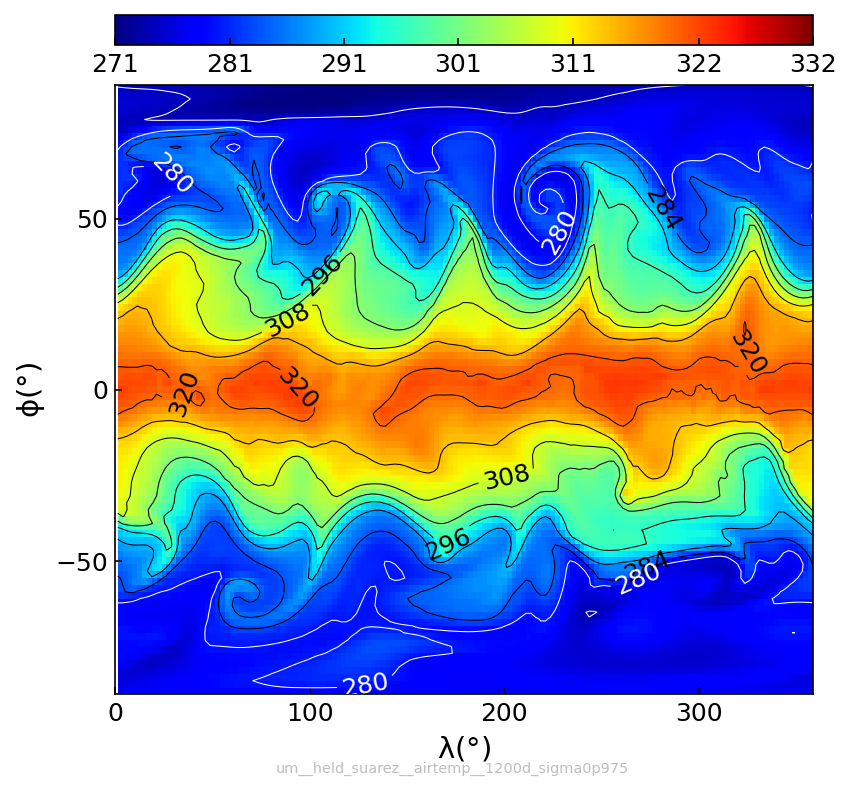

In [45]:
fig, (cax, ax) = plt.subplots(
    nrows=2,
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [0.05, 1], "hspace": 0.125},
)

p0 = ax.pcolormesh(
    lons, lats, airtemp_1200d_single_lev.data, cmap="jet", vmin=271, vmax=332
)
p1 = ax.contour(
    lons,
    lats,
    airtemp_1200d_single_lev.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(284, 400, 6),
)
c1 = ax.clabel(p1, levels=np.arange(284, 400, 12), fmt="%.0f", use_clabeltext=True)
p2 = ax.contour(
    lons,
    lats,
    airtemp_1200d_single_lev.data,
    colors="w",
    linewidths=0.5,
    levels=np.arange(100, 284, 6),
)
c2 = ax.clabel(p2, levels=np.arange(100, 284, 12), fmt="%.0f", use_clabeltext=True)
ax.tick_params(direction="in")
ax.set_xticks(np.arange(0, 360, 100))
ax.set_yticks(np.arange(-50, 51, 50))

cb = fig.colorbar(p0, orientation="horizontal", cax=cax)
cb.ax.tick_params(direction="in")
cb.set_ticks([271, 281, 291, 301, 311, 322, 332])

ax.set_xlabel("$\lambda$($\degree$)")
ax.set_ylabel("$\phi$($\degree$)")

imgname = plot_dir / "um__held_suarez__airtemp__1200d_sigma0p975"
figsave(fig, imgname)

##### Winds

In [46]:
# your code here (adapt the code cell below)

##### Better versions

And now using a function to streamline the process.

In [47]:
def horiz_cross(var_key, save=True, add_minmax=True, figsize=(9, 4.5), model=um):
    """Make a plot of a horizontal cross-section for a given cube."""
    fig, ax = plt.subplots(figsize=figsize)

    vrbl = VAR_PLOT_DICT[var_key]["cube"]
    lons, lats = vrbl.coord(model.x).points, vrbl.coord(model.y).points

    p0 = ax.contourf(lons, lats, vrbl.data, **VAR_PLOT_DICT[var_key]["kw_plt_cf"])
    p1 = ax.contour(lons, lats, vrbl.data, **VAR_PLOT_DICT[var_key]["kw_plt_c"])
    plt.setp(p1.collections, path_effects=PE)
    c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)
    plt.setp(c1, path_effects=PE)

    ax.set_xticks(np.arange(0, 361, 60))
    ax.set_yticks(np.arange(-90, 91, 30))

    ax.set_xlabel("Longitude [$\degree$]")
    ax.set_ylabel("Latitude [$\degree$]")
    ax.set_title(VAR_PLOT_DICT[var_key]["title"], loc="left")

    if add_minmax:
        at = AnchoredText(
            cube_stats_string(vrbl, sep="\n", fmt=".2f"), loc="upper left"
        )
        ax.add_artist(at)

    if save:
        imgname = plot_dir / f"um__held_suarez__{var_key}__new"
        figsave(fig, imgname)

Store all the plot settings in a dictionary, which will be used in the function above.

In [48]:
VAR_PLOT_DICT = {
    "airtemp__1200d_sigma0p975": {
        "title": f"{SIM_LABEL}\nAir temperature at 1200 days at $\sigma=0.975$",
        "cube": airtemp_1200d_single_lev,
        "kw_plt_cf": {
            "cmap": "plasma",
            "levels": np.arange(260, 330, 6),
        },
        "kw_plt_c": {
            "colors": "k",
            "linewidths": 0.5,
            "levels": np.arange(200, 400, 6),
        },
    },
    "u_tm_sigma0p975": {
        "title": f"{SIM_LABEL}\nTime mean of zonal wind at $\sigma=0.975$",
        "cube": u_tm.extract(iris.Constraint(**{um.s_p: 0.975})),
        "kw_plt_cf": {
            "cmap": "RdBu_r",
            "levels": np.arange(-20, 21, 5),
        },
        "kw_plt_c": {
            "colors": "k",
            "linewidths": 0.5,
            "levels": np.arange(-100, 100, 5),
        },
    },
    "u_tm_sigma0p525": {
        "title": f"{SIM_LABEL}\nTime mean of zonal wind at $\sigma=0.525$",
        "cube": u_tm.extract(iris.Constraint(**{um.s_p: 0.525})),
        "kw_plt_cf": {
            "cmap": "RdBu_r",
            "levels": np.arange(-20, 21, 5),  # ADJUST
        },
        "kw_plt_c": {
            "colors": "k",
            "linewidths": 0.5,
            "levels": np.arange(-100, 100, 5),  # ADJUST
        },
    },
    # "u_tm_sigma0p225": {}  # CONTINUE
    "v_tm_sigma0p975": {
        "title": f"{SIM_LABEL}\nTime mean of meridional wind at $\sigma=0.975$",
        "cube": v_tm.extract(iris.Constraint(**{um.s_p: 0.975})),
        "kw_plt_cf": {
            "cmap": "RdBu_r",
            "levels": np.arange(-15, 16, 5),  # ADJUST
        },
        "kw_plt_c": {
            "colors": "k",
            "linewidths": 0.5,
            "levels": np.arange(-100, 100, 5),  # ADJUST
        },
    },
    # "v_tm_sigma0p53": {}  # CONTINUE
}

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__airtemp__1200d_sigma0p975__new.png


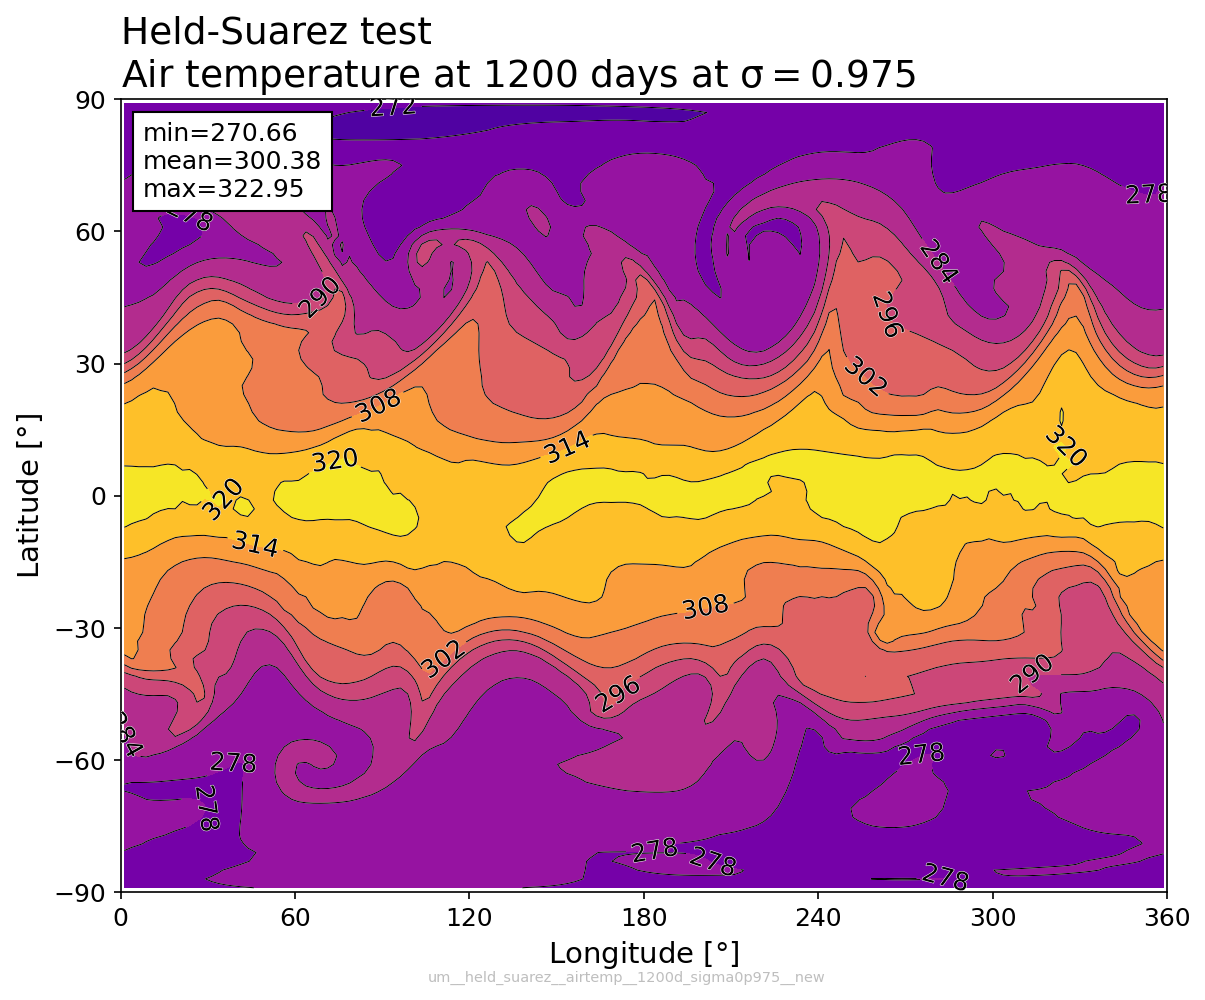

In [49]:
horiz_cross("airtemp__1200d_sigma0p975", figsize=(9, 7), save=True, add_minmax=True)

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__u_tm_sigma0p975__new.png


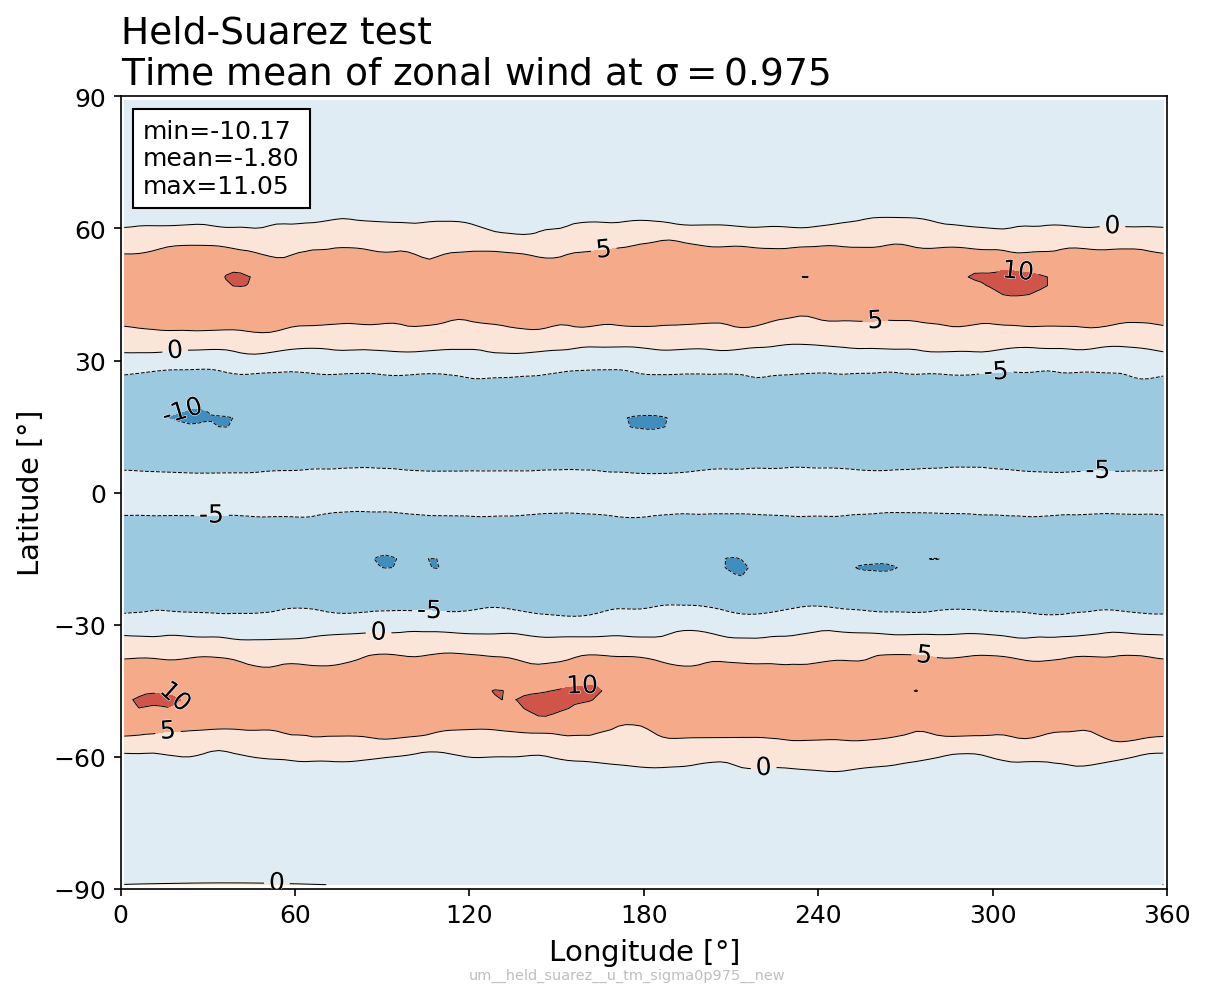

In [50]:
horiz_cross("u_tm_sigma0p975", figsize=(9, 7), save=True, add_minmax=True)

Saved to ../plots/mayne2014_gmd_plots/um__held_suarez__v_tm_sigma0p975__new.png


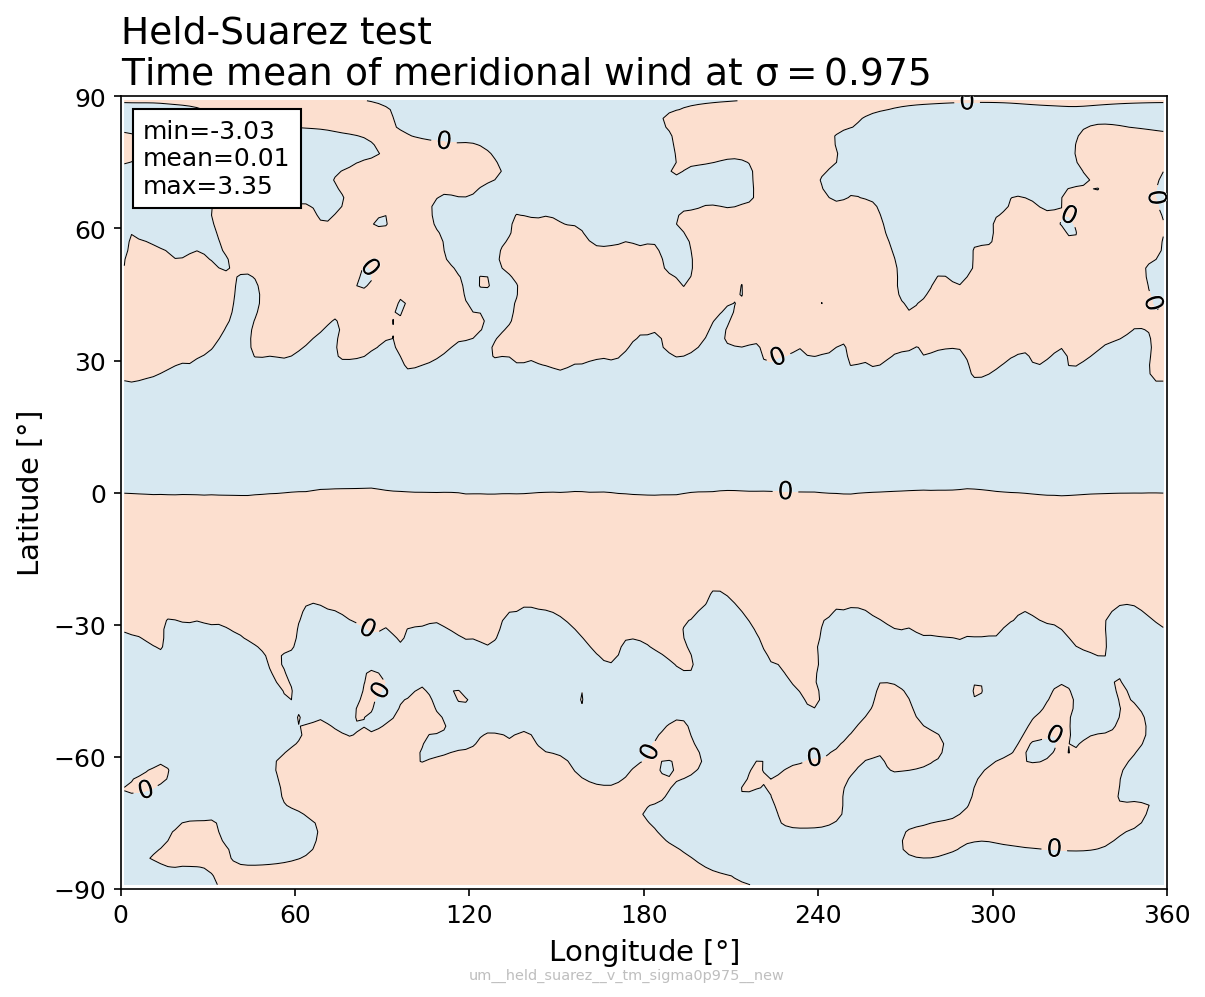

In [51]:
horiz_cross("v_tm_sigma0p975", figsize=(9, 7), save=True, add_minmax=True)